# Predicting the Time to Dispatch an Order

This notebook presents a solution to the (regression) task of predicting the time taken to dispatch an order placed on an eCommerce platform, given the number of order already placed that day.

## Imports

In [1]:
import os

import boto3 as aws
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor

## Configuration

In [2]:
AWS_S3_PROJECT_BUCKET = "bodywork-time-to-dispatch"
AWS_S3_DATASET_OBJECT = "datasets/time_to_dispatch_2021-07-01T16|45|38.csv"

sns.set()
s3 = aws.client('s3')

## Load Data from Cloud Object Storage

In [3]:
s3.download_file(AWS_S3_PROJECT_BUCKET, AWS_S3_DATASET_OBJECT, "training_data.csv")
dataset = pd.read_csv("training_data.csv")
dataset

,hours_to_dispatch,orders_placed,product_code
0,15.862959,112.0,SKU004
1,2.929956,7.0,SKU003
2,7.021040,63.0,SKU003
3,13.713052,100.0,SKU003
4,18.538162,173.0,SKU002
...,...,...,...
995,4.033392,28.0,SKU005
996,6.699361,46.0,SKU003
997,7.784548,41.0,SKU005
998,8.664694,83.0,SKU002


## Exploratory Data Analysis

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hours_to_dispatch  1000 non-null   float64
 1   orders_placed      1000 non-null   float64
 2   product_code       1000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 23.6+ KB


- labels: `hours_to_dispatch`
- features: `orders_placed` (numeric), `product_code` (categorical)

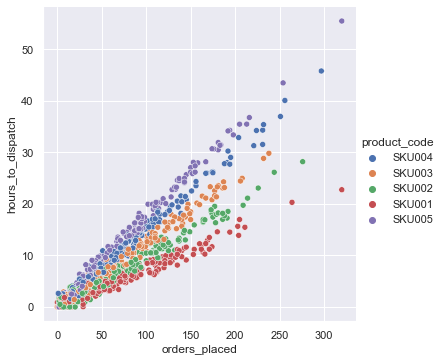

In [5]:
_ = sns.relplot(
    x="orders_placed", y="hours_to_dispatch", hue="product_code", data=dataset
)

**Notes**:
- Linear response, conditional on `product_type`.
- Homoscedastic.

## Split Data into Train and Test Subsets

Split labels from features and partition dataset.

In [6]:
X = dataset.drop("hours_to_dispatch", axis=1)
y = dataset["hours_to_dispatch"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=dataset["product_code"].values,
    random_state=42
)

## Data Preparation

Split labels from features and create a function to pre-process data into potential model features.

In [7]:
def preprocess(df: pd.DataFrame) -> np.ndarray:
    df_processed = df.copy()
    category_map = {"SKU001": 0, "SKU002": 1, "SKU003": 2, "SKU004": 3, "SKU005": 4}
    df_processed["product_code"] = df["product_code"].apply(lambda e: PRODUCT_CODE_MAP[e])
    return df_processed.values

preprocess(dataset)

array([[ 15.86295852, 112.        ,   3.        ],
       [  2.9299561 ,   7.        ,   2.        ],
       [  7.02103972,  63.        ,   2.        ],
       ...,
       [  7.78454797,  41.        ,   4.        ],
       [  8.66469389,  83.        ,   1.        ],
       [ 13.83025366,  81.        ,   4.        ]])

## Setup Model Metrics

We will use the Mean Absoloute Error (MAE) and $R^{2}$ metrics for this regression task.

In [8]:
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    mape = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE = {mape:.3f}")
    print(f"R^2 = {r2:.3f}")

## Train Model

We will train a decision tree, so that we can capture the non-linearities in the dataset, and we will start with the default parameters.

In [9]:
model = DecisionTreeRegressor(random_state=42)
model.fit(preprocess(X_train), y_train)

DecisionTreeRegressor(random_state=42)

### Diagnostics

MAE = 1.047
R^2 = 0.966


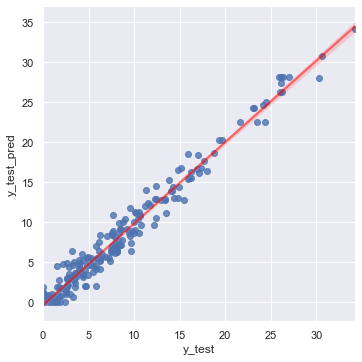

In [10]:
y_test_pred = model.predict(preprocess(X_test))
compute_metrics(y_test, y_test_pred)

_ = sns.lmplot(
    y="y_test_pred",
    x="y_test",
    data=pd.DataFrame({"y_test": y_test, "y_test_pred": y_test_pred}),
    line_kws={"color": "red", "alpha": 0.5}
)

This is an acceptable starting point.

### Hyperparameter Optimisation

MAE = 0.907
R^2 = 0.976

OPTIMAL HYPERPARAMETERS
criterion: mse
max_depth: 8
min_samples_leaf: 2
min_samples_split: 2
random_state: 42


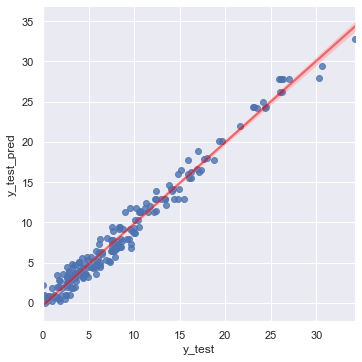

In [11]:
param_grid = {
    "random_state": [42],
    "criterion": ["mse", "mae"],
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10],
}

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="r2", cv=5, refit=True
)
grid_search.fit(preprocess(X_train), y_train)
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(preprocess(X_test))
compute_metrics(y_test, y_test_pred)

print("\nOPTIMAL HYPERPARAMETERS")
for k, v in grid_search.best_params_.items():
    print(f"{k}: {v}")

_ = sns.lmplot(
    y="y_test_pred",
    x="y_test",
    data=pd.DataFrame({"y_test": y_test, "y_test_pred": y_test_pred}),
    line_kws={"color": "red", "alpha": 0.5}
)

This is an improvement on the default values.

## Save Model to Cloud Object Storage

In [12]:
# persist trained model locally 
joblib.dump(best_model, "model.joblib")

# upload trained model to AWS S3
s3_client = aws.client('s3')
s3_client.upload_file(
    "model.joblib",
    AWS_S3_PROJECT_BUCKET,
    "models/model_2021-07-01T16|45|38.joblib"
)

# remove local files
os.remove("model.joblib")
os.remove("training_data.csv")